# Visual Anagrams: Generating Multi-View Optical Illusions with Diffusion Models

This colab notebook is optimized to generate  [visual anagrams and other multi-view optical illusions](https://github.com/dangeng/visual_anagrams) on systems with less memory. The code is based on the original [project notebook](https://colab.research.google.com/drive/1hCvJR5GsQrhH1ceDjdbzLG8y6m2UdJ6l?usp=sharing) and optimization techniquese described in Diffusers docs:

- 🚀 [Optimizing for inference time](https://huggingface.co/docs/diffusers/api/pipelines/if#optimizing-for-speed)
- ⚙️ [Optimizing for low memory during inference](https://huggingface.co/docs/diffusers/api/pipelines/if#optimizing-for-memory)

This optimization is enabled by the fact that Diffusers can modularly load individual components i.e. we can load the text encoder without loading the UNet. This modular loading will ensure that we only load the component we need at a given step in the pipeline to avoid exhausting the available CPU RAM and GPU VRAM.

This notebook was tested working fine on colab free as well as a local machine with 12GiB vRAM.

In [1]:
from huggingface_hub import login
login()

## Install Dependencies

Run the below to install dependencies, including [the `visual_anagrams` repo](https://github.com/dangeng/VisualAnagrams_prerelease) which will do the heavy lifting.

In [2]:
! pip install -q \
  diffusers \
  transformers \
  safetensors \
  sentencepiece \
  accelerate \
  bitsandbytes \
  einops \
  mediapy \
  accelerate

!pip install -q git+https://github.com/dangeng/visual_anagrams.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Free memory
Helper functions to free memory.

In [3]:
import gc
import torch

def flush():
    gc.collect()
    torch.cuda.empty_cache()

## Import Dependencies and Misc Setup

We import packages we need and define some useful functions

In [4]:
import mediapy as mp

import torch
from diffusers import DiffusionPipeline

from visual_anagrams.views import get_views
from visual_anagrams.samplers import sample_stage_1, sample_stage_2
from visual_anagrams.utils import add_args, save_illusion, save_metadata

device = 'cuda'

def im_to_np(im):
  im = (im / 2 + 0.5).clamp(0, 1)
  im = im.detach().cpu().permute(1, 2, 0).numpy()
  im = (im * 255).round().astype("uint8")
  return im

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Load TextEncoder Model
We will load `T5` model in half-precision (`fp16`). We will also use the `device_map` flag to allow transformers to offload model layers to the CPU or disk. Transformers big modeling supports arbitrary device maps, which can be used to separately load model parameters directly to available devices. Passing `"auto"` will automatically create a device map. See the `transformers` [docs](https://huggingface.co/docs/accelerate/usage_guides/big_modeling#designing-a-device-map) for more information.

### Addendum
To further reduce memory utilization we can also load `T5` using `8bit` quantization. Transformers directly supports [bitsandbytes](https://huggingface.co/docs/transformers/main/en/main_classes/quantization#load-a-large-model-in-8bit) through the `load_in_8bit` flag. The flag `variant="8bit"` needs to be set download pre-quantized weights. For example, this should allow loading `T5` checkpoint in as little as 8GB memory.

```python
T5EncoderModel.from_pretrained("DeepFloyd/IF-I-M-v1.0",subfolder="text_encoder", device_map="auto", load_in_8bit=True, variant="8bit")
```


In [5]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    subfolder="text_encoder",
    device_map="auto",
    variant="fp16",
    torch_dtype=torch.float16,
)


text_encoder/config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

(…)ncoder/model.safetensors.index.fp16.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

model.fp16-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model.fp16-00002-of-00002.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

##  Create text embeddings

The Diffusers API for accessing diffusion models is the `DiffusionPipeline` class and its subclasses. Each instance of `DiffusionPipeline` is a fully self contained set of methods and models for running diffusion networks. We can override the models it uses by passing alternative instances as keyword arguments to `from_pretrained`.

In this case, we pass None for the unet argument, so no UNet will be loaded. This allows us to run the text embedding portion of the diffusion process without loading the UNet into memory.

In [6]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    text_encoder=text_encoder, # pass the previously instantiated text encoder
    unet=None
)

model_index.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

watermarker/config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
# Feel free to change me:
prompts = [
      'an oil painting of a deer',
      'an oil painting of a waterfall',
    ]

# Embed prompts using the T5 model
prompt_embeds = [pipe.encode_prompt(prompt) for prompt in prompts]
prompt_embeds, negative_prompt_embeds = zip(*prompt_embeds)
prompt_embeds = torch.cat(prompt_embeds)
negative_prompt_embeds = torch.cat(negative_prompt_embeds)  # These are just null embeds

Flush to free memory for the next stages

In [8]:
del text_encoder
del pipe
flush()

## Main Diffusion Process

With our now available GPU memory, we can re-load the DiffusionPipeline with only the UNet to run the main diffusion process.

The variant and torch_dtype flags are used by Diffusers to download and load the weights in 16 bit floating point format.

In [14]:
from diffusers import DiffusionPipeline

stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
)

stage_1.enable_model_cpu_offload()
stage_1.to('cuda')


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components tokenizer, text_encoder, unet, scheduler, safety_checker, feature_extractor, watermarker to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


IFPipeline {
  "_class_name": "IFPipeline",
  "_diffusers_version": "0.25.1",
  "_name_or_path": "DeepFloyd/IF-I-L-v1.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "deepfloyd_if",
    "IFSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "T5Tokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "watermarker": [
    "deepfloyd_if",
    "IFWatermarker"
  ]
}

In [15]:
stage_2 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-II-L-v1.0",
                text_encoder=None,
                variant="fp16",
                torch_dtype=torch.float16,
              )
stage_2.enable_model_cpu_offload()
stage_2.to('cuda')


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components tokenizer, text_encoder, unet, scheduler, image_noising_scheduler, safety_checker, feature_extractor, watermarker to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move 

IFSuperResolutionPipeline {
  "_class_name": "IFSuperResolutionPipeline",
  "_diffusers_version": "0.25.1",
  "_name_or_path": "DeepFloyd/IF-II-L-v1.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_noising_scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "deepfloyd_if",
    "IFSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "T5Tokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "watermarker": [
    "deepfloyd_if",
    "IFWatermarker"
  ]
}

Choose one of the view transformations supported by Visual Anagrams repo

In [16]:
# UNCOMMENT ONE OF THESE

# views = get_views(['identity', 'rotate_180'])
# views = get_views(['identity', 'rotate_cw'])
# views = get_views(['identity', 'flip'])
# views = get_views(['identity', 'jigsaw'])
views = get_views(['identity', 'negate'])
# views = get_views(['identity', 'skew'])
# views = get_views(['identity', 'patch_permute'])
# views = get_views(['identity', 'pixel_permute'])
# views = get_views(['identity', 'inner_circle'])

## Generate Illusions
Now, we can sample illusions by denoising all views at once. The `sample_stage_1` function does this and generates a $64 \times 64$ image. The `sample_stage_2` function upsamples the resulting image while denoising all views, and generates a $256 \times 256$ image.

100%|██████████| 40/40 [00:08<00:00,  4.95it/s]


,

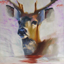
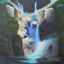

In [19]:
image_64 = sample_stage_1(stage_1,
                          prompt_embeds,
                          negative_prompt_embeds,
                          views,
                          num_inference_steps=40,
                          guidance_scale=10.0,
                          reduction='mean',
                          generator=None)
mp.show_images([im_to_np(view.view(image_64[0])) for view in views])

100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


,

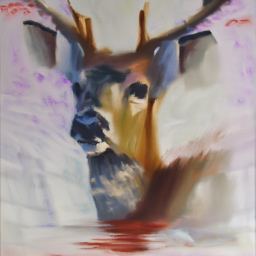
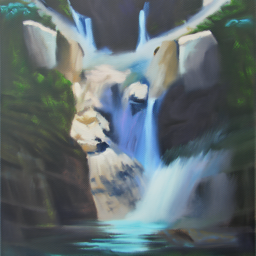

In [20]:
image = sample_stage_2(stage_2,
                       image_64,
                       prompt_embeds,
                       negative_prompt_embeds,
                       views,
                       num_inference_steps=30,
                       guidance_scale=10.0,
                       reduction='mean',
                       noise_level=50,
                       generator=None)
mp.show_images([im_to_np(view.view(image[0])) for view in views])